In [28]:
#install pandas-datareader package with pip
#!pip install pandas-datareader

In [29]:
#import libraries
import datetime as dt
import math

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sn

import pandas as pd
import pandas_datareader as web

import numpy as np
import statsmodels
from statsmodels.tsa.stattools import coint

np.random.seed(107)


In [30]:
start = dt.date(2019,1,1)
end = dt.date.today()

In [31]:
#symbol_list = ['IG', 'NVS', 'PBH', 'GNC', 'JNJ', 'PFE', 'MRTX','SPX', 'CPHD']

symbol_list = ['NVS', 'PBH']

df_stock_prices = pd.DataFrame()

In [32]:
for symbol in symbol_list:
  try:
    df = web.DataReader(symbol, 'yahoo', start, end)
    df_stock_prices[symbol] = df['Adj Close']
  except:
    pass

In [33]:
df_stock_prices.head()

,NVS,PBH
Date,,
2019-01-02,70.406586,30.709999
2019-01-03,70.976135,30.209999
2019-01-04,71.939354,31.379999
2019-01-07,71.093399,31.440001
2019-01-08,72.634537,31.719999


In [34]:
def find_cointegrated_pairs(stockprice_data):
  symb = list(df_stock_prices.columns)
  n = len(symb)
  score_matrix = np.zeros((n,n))
  pvalue_matrix = np.ones((n,n))
  pairs = []

  for i in range(n):
    for j in range(i+1, n):
      S1 = stockprice_data[symb[i]]
      S2 = stockprice_data[symb[j]]
      S1 = S1.fillna(S1.mean())
      S2 = S2.fillna(S2.mean())
      result = coint(S1,S2)
      score = result[0]
      pvalue = result[1]
      score_matrix[i,j] = score
      pvalue_matrix[i,j] = pvalue

      if(pvalue < 0.01):
        pairs.append((S1,S2,symb[i], symb[j]))
  return score_matrix, pvalue_matrix, pairs

In [35]:
score, pvalue, _ = find_cointegrated_pairs(df_stock_prices)

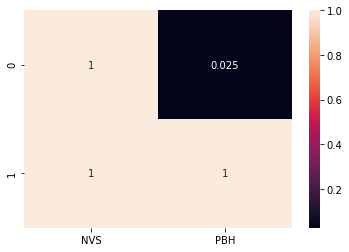

In [36]:
df_pvalue = pd.DataFrame(pvalue, columns=list(df_stock_prices.columns))
sn.heatmap(df_pvalue, annot=True)
plt.show()

#Week 8

## Visualize the Time Series in Graph

In [37]:
X = df_stock_prices['NVS']
Y = df_stock_prices['PBH']

In [38]:
print("Correlation : " , X.corr(Y))
print("Cointegration test p-value : ", pvalue[0][1])

Correlation :  0.708861839412714
Cointegration test p-value :  0.025479193494852313


We see that these two stock prices are both cointegrated and correlated.

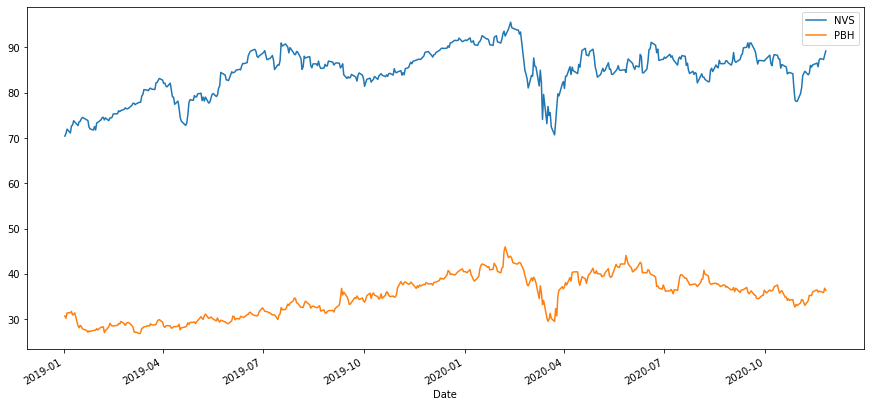

In [39]:
s1 = X
s2 = Y

pd.concat([s1, s2], axis=1 ).plot(figsize=(15,7))
plt.show()


## How to make a pairs trade ?

Because two cointegrated time series (such as X and Y above) drift towards and apart from each other, there will be times when the spread is high and times when the spread is low.

We make a pairs trade by buying one security and selling another. This way, if both securities go down together or go up together, we neither make nor lose money — we are market neutral.

##Getting Ratio of time series

In [40]:
ratios = s1 / s2

##Z-Score

$ZScore(Value) = (Value - Mean) / Standard Deviation$

In [41]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

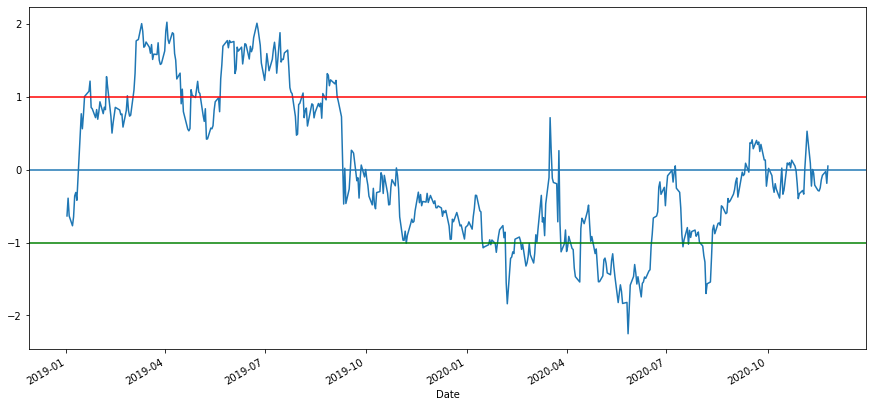

In [42]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

It’s easier to now observe the ratio now moves around the mean, but sometimes is prone to large divergences from the mean, which we can take advantages of.

**By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converge back. This is precisely what we want for a pairs trading strategy.**

##Trading Signals

When conducting any type of trading strategy, it's always important to clearly define and delineate at what point you will actually make a trade. As in, what is the best indicator that I need to buy or sell a particular stock?

###Setup rules

We're going to use the **ratio** time series that we've created to see if it tells us whether to buy or sell a particular moment in time.

 We'll start off by creating a prediction variable Y

. If the ratio is positive, it will signal a "buy," otherwise, it will signal a sell. The prediction model is as follows:



$Y_t=sign(Ratio_{t+1} - Ratio_t)$

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.

In [60]:
#signal of sell
ratios[0] - ratios[1]

-0.05679785892271472

In [59]:
#signal of buy
ratios[1] - ratios[2]

0.056902775776478176

##Train Test Split

In [61]:
print(len(ratios) * .70 )

336.7


In [62]:
train = ratios[:336]
test = ratios[336:]

In [63]:
train.head()

Date
2019-01-02    2.292627
2019-01-03    2.349425
2019-01-04    2.292522
2019-01-07    2.261240
2019-01-08    2.289866
dtype: float64

In [64]:
test.head()

Date
2020-05-04    2.101051
2020-05-05    2.152654
2020-05-06    2.158028
2020-05-07    2.140834
2020-05-08    2.110586
dtype: float64

##Feature Engineering

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.


* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z score


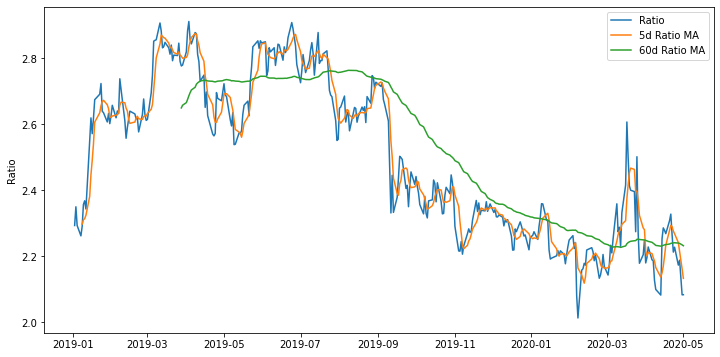

In [65]:
ratios_mavg60 = train.rolling(window=60, center=False).mean()
ratios_mavg5 = train.rolling(window=5, center=False).mean()

std_60 = train.rolling(window=60, center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

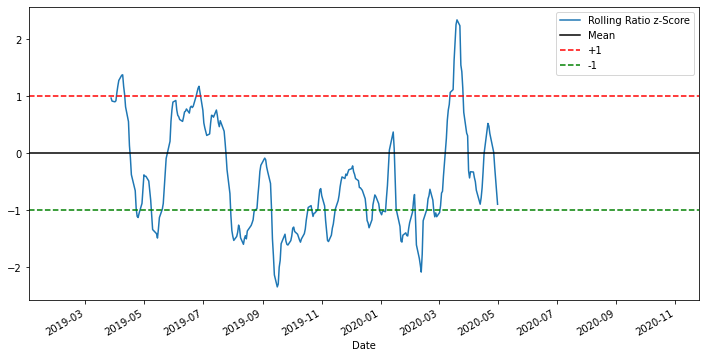

In [70]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2019-01-02', '2020-11-25')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

## Creating a Model

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

    Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
    Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

We can use our model on actual data

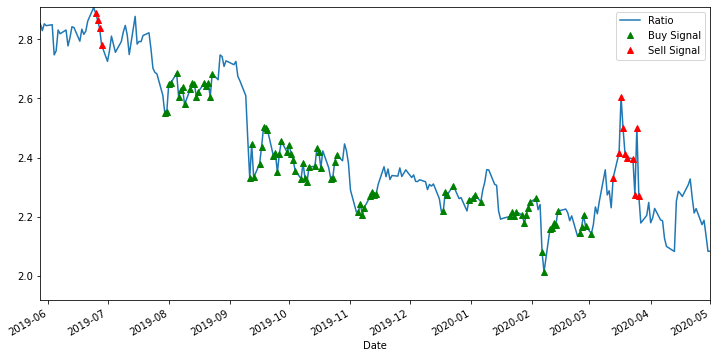

In [77]:
plt.figure(figsize=(12,6))

train[100:].plot()

buy = train.copy()
sell = train.copy()

#Buy signal (1) whenever the z-score is below -1, meaning we expect the ratio to increase.
buy[zscore_60_5>-1] = 0

#Sell signal (-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.
sell[zscore_60_5<1] = 0

buy[100:].plot(color='g', linestyle='None', marker='^')
sell[100:].plot(color='r', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2019-05-28','2020-05-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

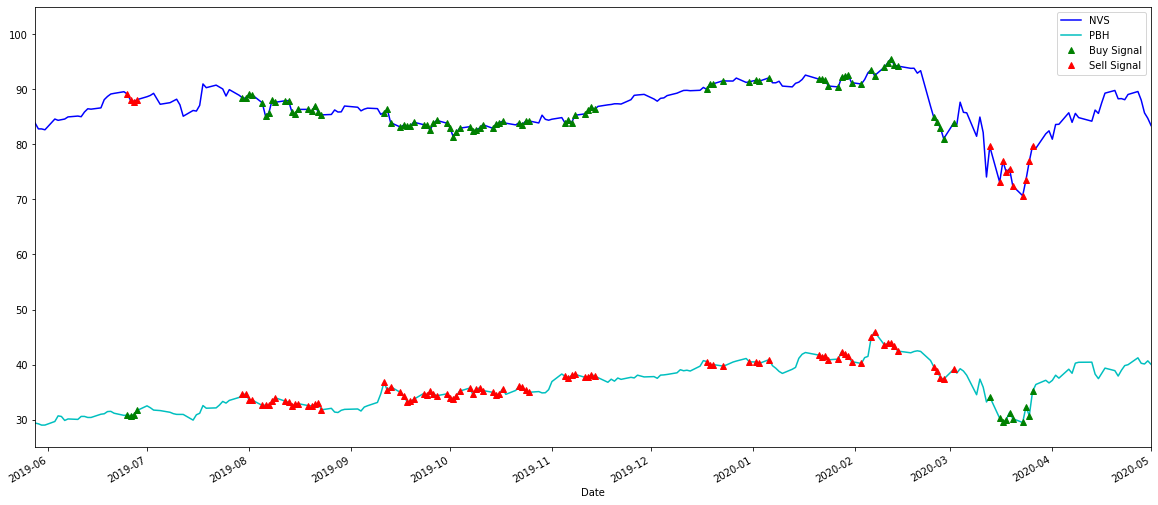

In [96]:
plt.figure(figsize=(20,9))

S1 = df_stock_prices['NVS'].iloc[:336]
S2 = df_stock_prices['PBH'].iloc[:336]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2019-05-28', '2020-05-01')

plt.legend(['NVS', 'PBH', 'Buy Signal', 'Sell Signal'])
plt.show()

Now we can clearly see when we should buy or sell on the respective stocks.

##how much can we expect to make of this strategy?

In [131]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2

    #get moving average of first window
    ma1 = ratios.rolling(window=window1, center=False).mean()

    #get moving average of second window
    ma2 = ratios.rolling(window=window2, center=False).mean()

    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [132]:
S1 = df_stock_prices['NVS'].iloc[:336]
S2 = df_stock_prices['PBH'].iloc[:336]

trade(S1,S2,60,5)

Selling Ratio 0.0 2.776671704893592 -1 2.776671704893592
Selling Ratio 0.0 2.779347119214838 -2 5.556018824108429
Selling Ratio 0.0 2.8197090263339533 -3 8.375727850442383
Selling Ratio 0.0 2.883682844066577 -4 11.25941069450896
Selling Ratio 0.0 2.9117004472529513 -5 14.17111114176191
Selling Ratio 0.0 2.8565948049227785 -6 17.02770594668469
Selling Ratio 0.0 2.8436392559044554 -7 19.871345202589147
Selling Ratio 0.0 2.8781208255850084 -8 22.749466028174155
Selling Ratio 0.0 2.8746130807059154 -9 25.62407910888007
Selling Ratio 0.0 2.8115571486603894 -10 28.43563625754046
Selling Ratio 0.0 2.790642578422786 -11 31.226278835963246
Selling Ratio 0.0 2.7302597491338916 -12 33.956538585097135
Selling Ratio 0.0 2.748942787259153 -13 36.70548137235629
Exit pos 64.75238371697674 2.6510279044188474 0 0
Exit pos 64.75238371697674 2.6977622212934196 0 0
Buying Ratio 64.75238371697674 2.5701045632660007 1 -2.5701045632660007
Buying Ratio 64.75238371697674 2.5645010757219424 2 -5.134605638987943


592.7846415837278

Not a bad profit for a strategy that is made from stratch.

### Understanding Pandas DataFrame Conditions

Look at the shape of S1 which is

  ``` df_stock_prices['NVS'].iloc[:336] ```

so, its shape is (336,)

In [119]:
S1.shape

(336,)

In [124]:
[zscore_60_5>-1]

[Date
 2019-01-02    False
 2019-01-03    False
 2019-01-04    False
 2019-01-07    False
 2019-01-08    False
               ...  
 2020-04-27     True
 2020-04-28     True
 2020-04-29     True
 2020-04-30     True
 2020-05-01     True
 Length: 336, dtype: bool]

We have ``` buy ``` series which is signal according to the zvalue recall these lines;

```python
#Buy signal (1) whenever the z-score is below -1, meaning we expect the ratio to increase.
#we eliminate the above of the sell signal
buy[zscore_60_5>-1] = 0

#Sell signal (-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.
#we eminate the below of the sell signal
sell[zscore_60_5<1] = 0
```


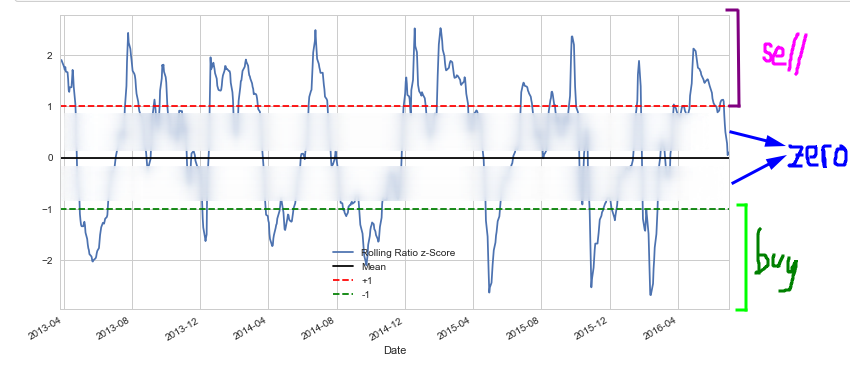

In [122]:
buy

Date
2019-01-02    2.292627
2019-01-03    2.349425
2019-01-04    2.292522
2019-01-07    2.261240
2019-01-08    2.289866
                ...   
2020-04-27    0.000000
2020-04-28    0.000000
2020-04-29    0.000000
2020-04-30    0.000000
2020-05-01    0.000000
Length: 336, dtype: float64

Eliminate the rows which does not include signal, these are 

In [117]:
S1[buy!=0].shape

(157,)